In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
import matplotlib
import operator
from rfpimp import *
from scipy.spatial.distance import pdist, squareform
from dynamicTreeCut import cutreeHybrid
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cophenet, fcluster
from itertools import compress
import networkx as nx
import itertools

# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 10

# import custom functions
from functions_statistical_performance import *

# Modified functions from rfpimp

In [2]:
# custom feature importance version with cross validation
def cv_importances_custom(X_train,y_train,splits, smoteflag):
    accuracy_baseline=Accuracykfold(X_train,y_train,splits,smoteflag)
    X_train = X_train.copy(deep=False)  # shallow copy
    baseline = np.mean(accuracy_baseline)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = np.mean(Accuracykfold(X_train,y_train,splits,smoteflag))
        X_train[col] = save
        imp.append(baseline - m)

    I = pd.DataFrame(data={'Feature': X_train.columns, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    return I

# custom feature importance version with cross validation with feature grouping   
def cv_importances_features_custom(X_train,y_train,splits, smoteflag, features):
    accuracy_baseline=Accuracykfold(X_train,y_train,splits,smoteflag)
    X_train = X_train.copy(deep=False)  # shallow copy
    baseline = np.mean(accuracy_baseline)    
    
    imp = []
    for group in features:
        save = X_train[group].copy()
        X_train[group] = np.random.permutation(X_train[group])
        m = np.mean(Accuracykfold(X_train,y_train,splits,smoteflag))
        X_train[group] = save
        imp.append(baseline - m)

    # Convert and groups/lists into string column names
    labels = []
    for col in features:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    I = pd.DataFrame(data={'Feature': labels, 'Importance': np.array(imp)})
    I = I.set_index('Feature')
    return I

# Load Training Data

In [3]:
RFFNDDS=pd.read_csv('./input_data/FNDDS_2009-10_Training_Data.csv')
# nutrient list
nl=list(RFFNDDS.columns)
nl=nl[0:-7]

# Eliminate all the "Total Measurments"

In [4]:
selnut=['Protein','Alcohol', 'Water', 'Caffeine',
       'Theobromine', 'Sugars, total', 'Fiber, total dietary', 'Calcium',
       'Iron', 'Magnesium', 'Phosphorus', 'Potassium', 'Sodium', 'Zinc',
       'Copper', 'Selenium', 'Retinol', 'Carotene, beta', 'Carotene, alpha',
       'Vitamin E (alpha-tocopherol)', 'Vitamin D (D2 + D3)',
       'Cryptoxanthin, beta', 'Lycopene', 'Lutein + zeaxanthin', 'Vitamin C',
       'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B-6',
       'Vitamin B-12', 'Choline, total', 'Vitamin K (phylloquinone)',
       'Folic acid', 'Folate, food', 'Vitamin E, added', 'Vitamin B-12, added',
       'Cholesterol', '4:00', '6:00', '8:00',
       '10:00', '12:00', '14:00', '16:00', '18:00', '18:01', '18:02', '18:03',
       '20:04', '22:6 n-3', '16:01', '18:04', '20:01', '20:5 n-3', '22:01',
       '22:5 n-3','Daidzein', 'Genistein',
       'Glycitein', 'Cyanidin', 'Petunidin', 'Delphinidin', 'Malvidin',
       'Pelargonidin', 'Peonidin', '(+)-Catechin', '(-)-Epigallocatechin',
       '(-)-Epicatechin', '(-)-Epicatechin 3-gallate',
       '(-)-Epigallocatechin 3-gallate', 'Theaflavin', 'Thearubigins',
       'Eriodictyol', 'Hesperetin', 'Naringenin', 'Apigenin', 'Luteolin',
       'Isorhamnetin', 'Kaempferol', 'Myricetin', 'Quercetin',
       "Theaflavin-3,3'-digallate", "Theaflavin-3'-gallate",
       'Theaflavin-3-gallate', '(+)-Gallocatechin']

# Performance Whole Panel

In [5]:
# Whole Nutrient Panel
#data to train  and cross validate
data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
X=data2train.loc[:, 'Protein': 'Total isoflavones']
y=data2train['pythonlabel']
print("Data Shape", X.shape)

smoteflag=False
(performancesAUCWNP, performancesAUPWNP, splitsWNP, model_per_foldWNP)=AUCAUPkfold(X,y,smoteflag);
# to create ROC curves
(performancesAUCWNP, performancesROCWNP, mean_fprWNP, mean_tprWNP, std_tprWNP, tprs_upperWNP, tprs_lowerWNP)=ROCkfold(X,y,splitsWNP)
# to create Precision-Recall curves
(performancesAUPWNP, performancesPrecisionRecallWNP, mean_recallWNP, mean_precisionWNP, std_precisionWNP, precision_upperWNP, precision_lowerWNP)=PrecisionRecallCurvekfold(X,y,splitsWNP)

print("k-fold Accuracy")
Accuracykfold(X,y,splitsWNP)

Data Shape (2971, 99)
AUC: average over the folds
[0.98035757 0.97583505 0.97062249 0.98170428]
AUC: std over the folds
[0.00358883 0.03264457 0.00404052 0.00177691]
AUP: average over the folds
[0.88630663 0.79475897 0.88296239 0.99244832]
AUP: std over the folds
[0.023284   0.09698542 0.0209234  0.00052889]
AUC: average over the folds
[0.98035757 0.97583505 0.97062249 0.98170428]
AUC: std over the folds
[0.00358883 0.03264457 0.00404052 0.00177691]
AUP: average over the folds
[0.88630663 0.79475897 0.88296239 0.99244832]
AUP: std over the folds
[0.023284   0.09698542 0.0209234  0.00052889]
k-fold Accuracy


array([[0.91596639],
       [0.8989899 ],
       [0.91077441],
       [0.91750842],
       [0.91582492]])

# Performance Reduced Panel

In [6]:
#data to train  and cross validate
data2train=RFFNDDS[RFFNDDS.pythonlabel!=-1]
Xsel=data2train.loc[:, selnut]
y=data2train['pythonlabel']
print("Data Shape", Xsel.shape)

smoteflag=False
#same splits as before
# to create ROC curves
(performancesAUCs, performancesROCs, mean_fprs, mean_tprs, std_tprs, tprs_uppers, tprs_lowers)=ROCkfold(Xsel,y,splitsWNP,smoteflag)
# to create Precision-Recall curves
(performancesAUPs, performancesPrecisionRecalls, mean_recalls, mean_precisions, std_precisions, precision_uppers, precision_lowers)=PrecisionRecallCurvekfold(Xsel,y,splitsWNP)

print("k-fold Accuracy")
Accuracykfold(Xsel,y,splitsWNP)

Data Shape (2971, 85)
AUP: average over the folds
[0.89621308 0.80181737 0.88727379 0.99255264]
AUP: std over the folds
[0.01333422 0.09598251 0.01512411 0.00052293]
k-fold Accuracy


array([[0.92436975],
       [0.90740741],
       [0.90572391],
       [0.90740741],
       [0.91919192]])

# Dependence Analysis

In [7]:
Dsel = feature_dependence_matrix(Xsel)

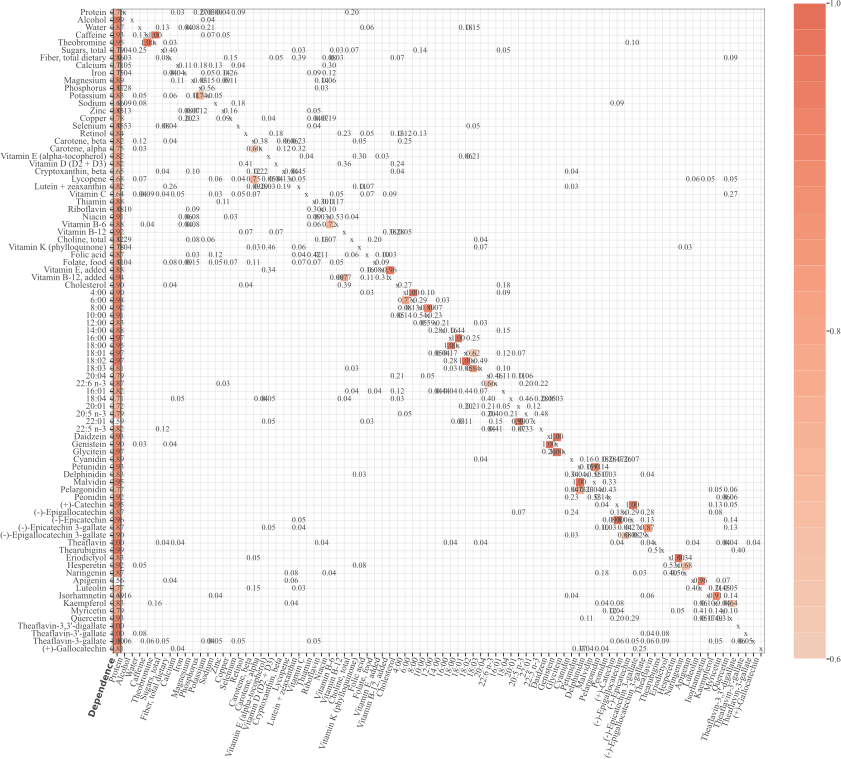

In [8]:
vizsel = plot_dependence_heatmap(Dsel, figsize=(12,12))
vizsel

In [9]:
# remove ones given by diagonals 
DmatrixSel=Dsel[selnut].values
np.fill_diagonal(DmatrixSel, 0)
Dsel

,Dependence,Protein,Alcohol,Water,Caffeine,Theobromine,"Sugars, total","Fiber, total dietary",Calcium,Iron,...,Apigenin,Luteolin,Isorhamnetin,Kaempferol,Myricetin,Quercetin,"Theaflavin-3,3'-digallate",Theaflavin-3'-gallate,Theaflavin-3-gallate,(+)-Gallocatechin
Protein,0.759519,1,0,0.0210586,0.0183804,0,0.00917604,0.0155831,0.0305631,0.0137814,...,0,0,0,0,0.00159244,0.00164183,0,0,0,0
Alcohol,0.991585,0.016676,1,0.0246125,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Water,0.871863,0.0141631,0,1,0,0,0.131926,0.00229861,0,0.0415691,...,0,0,0,0,0,0,0,0,0,0
Caffeine,0.92925,0.00303766,0.0128291,0.131667,1,1,0,0,0,0.00389597,...,0,0,0,0.00116763,0,0.00174624,0.00116691,0,0,0
Theobromine,0.948851,0.0018112,0,0,1,1,0.0134389,0.0323521,0,0,...,0,0,0,0,0,0.00127042,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Quercetin,0.931863,0,0,0.00200036,0,0,0.00279466,0,0.00276605,0.00185984,...,0,0.0489492,0.173411,0.492015,0.30834,1,0,0,0,0
"Theaflavin-3,3'-digallate",0.99798,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.025641,0
Theaflavin-3'-gallate,0.997307,0,0,0.0833615,0.0277919,0,0,0.0277919,0,0,...,0,0,0,0.0277919,0.0277919,0,0.0277919,1,0,0.0277919
Theaflavin-3-gallate,0.998317,0.0554267,0,0,0.0554267,0,0.0484848,0.00694183,0,0,...,0.00694183,0,0,0.0484848,0.0149493,0.00694183,0.0554267,0.0484848,1,0.0149493


# Correlation Analysis in the Training Data

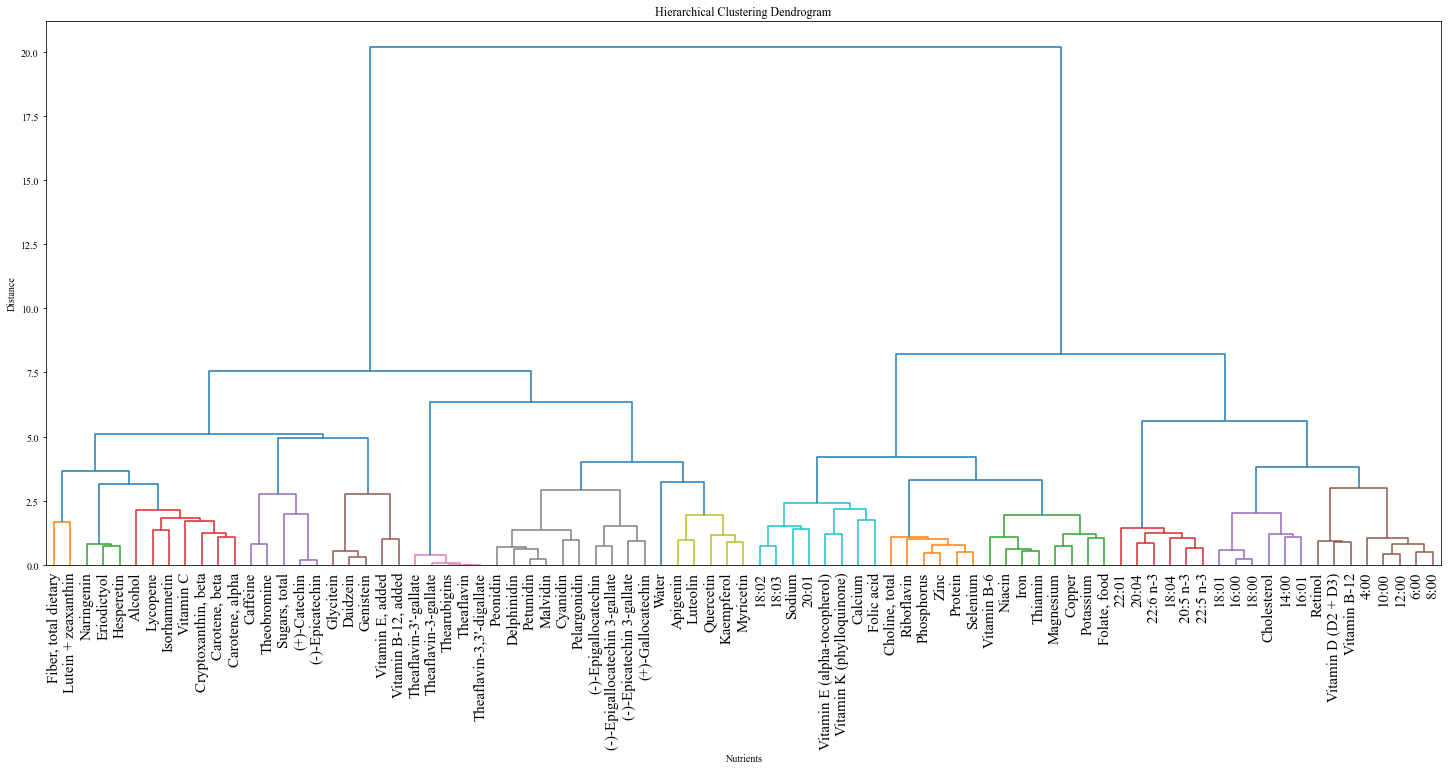

In [10]:
corrmatSS=Xsel.corr(method='spearman')
distancesSS = pdist(corrmatSS, 'euclidean')
linkSS = sch.linkage(distancesSS, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Nutrients')
plt.ylabel('Distance')
d=sch.dendrogram(
    linkSS,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=15.,  # font size for the x axis labels
    labels=corrmatSS.index,
    color_threshold=3
);

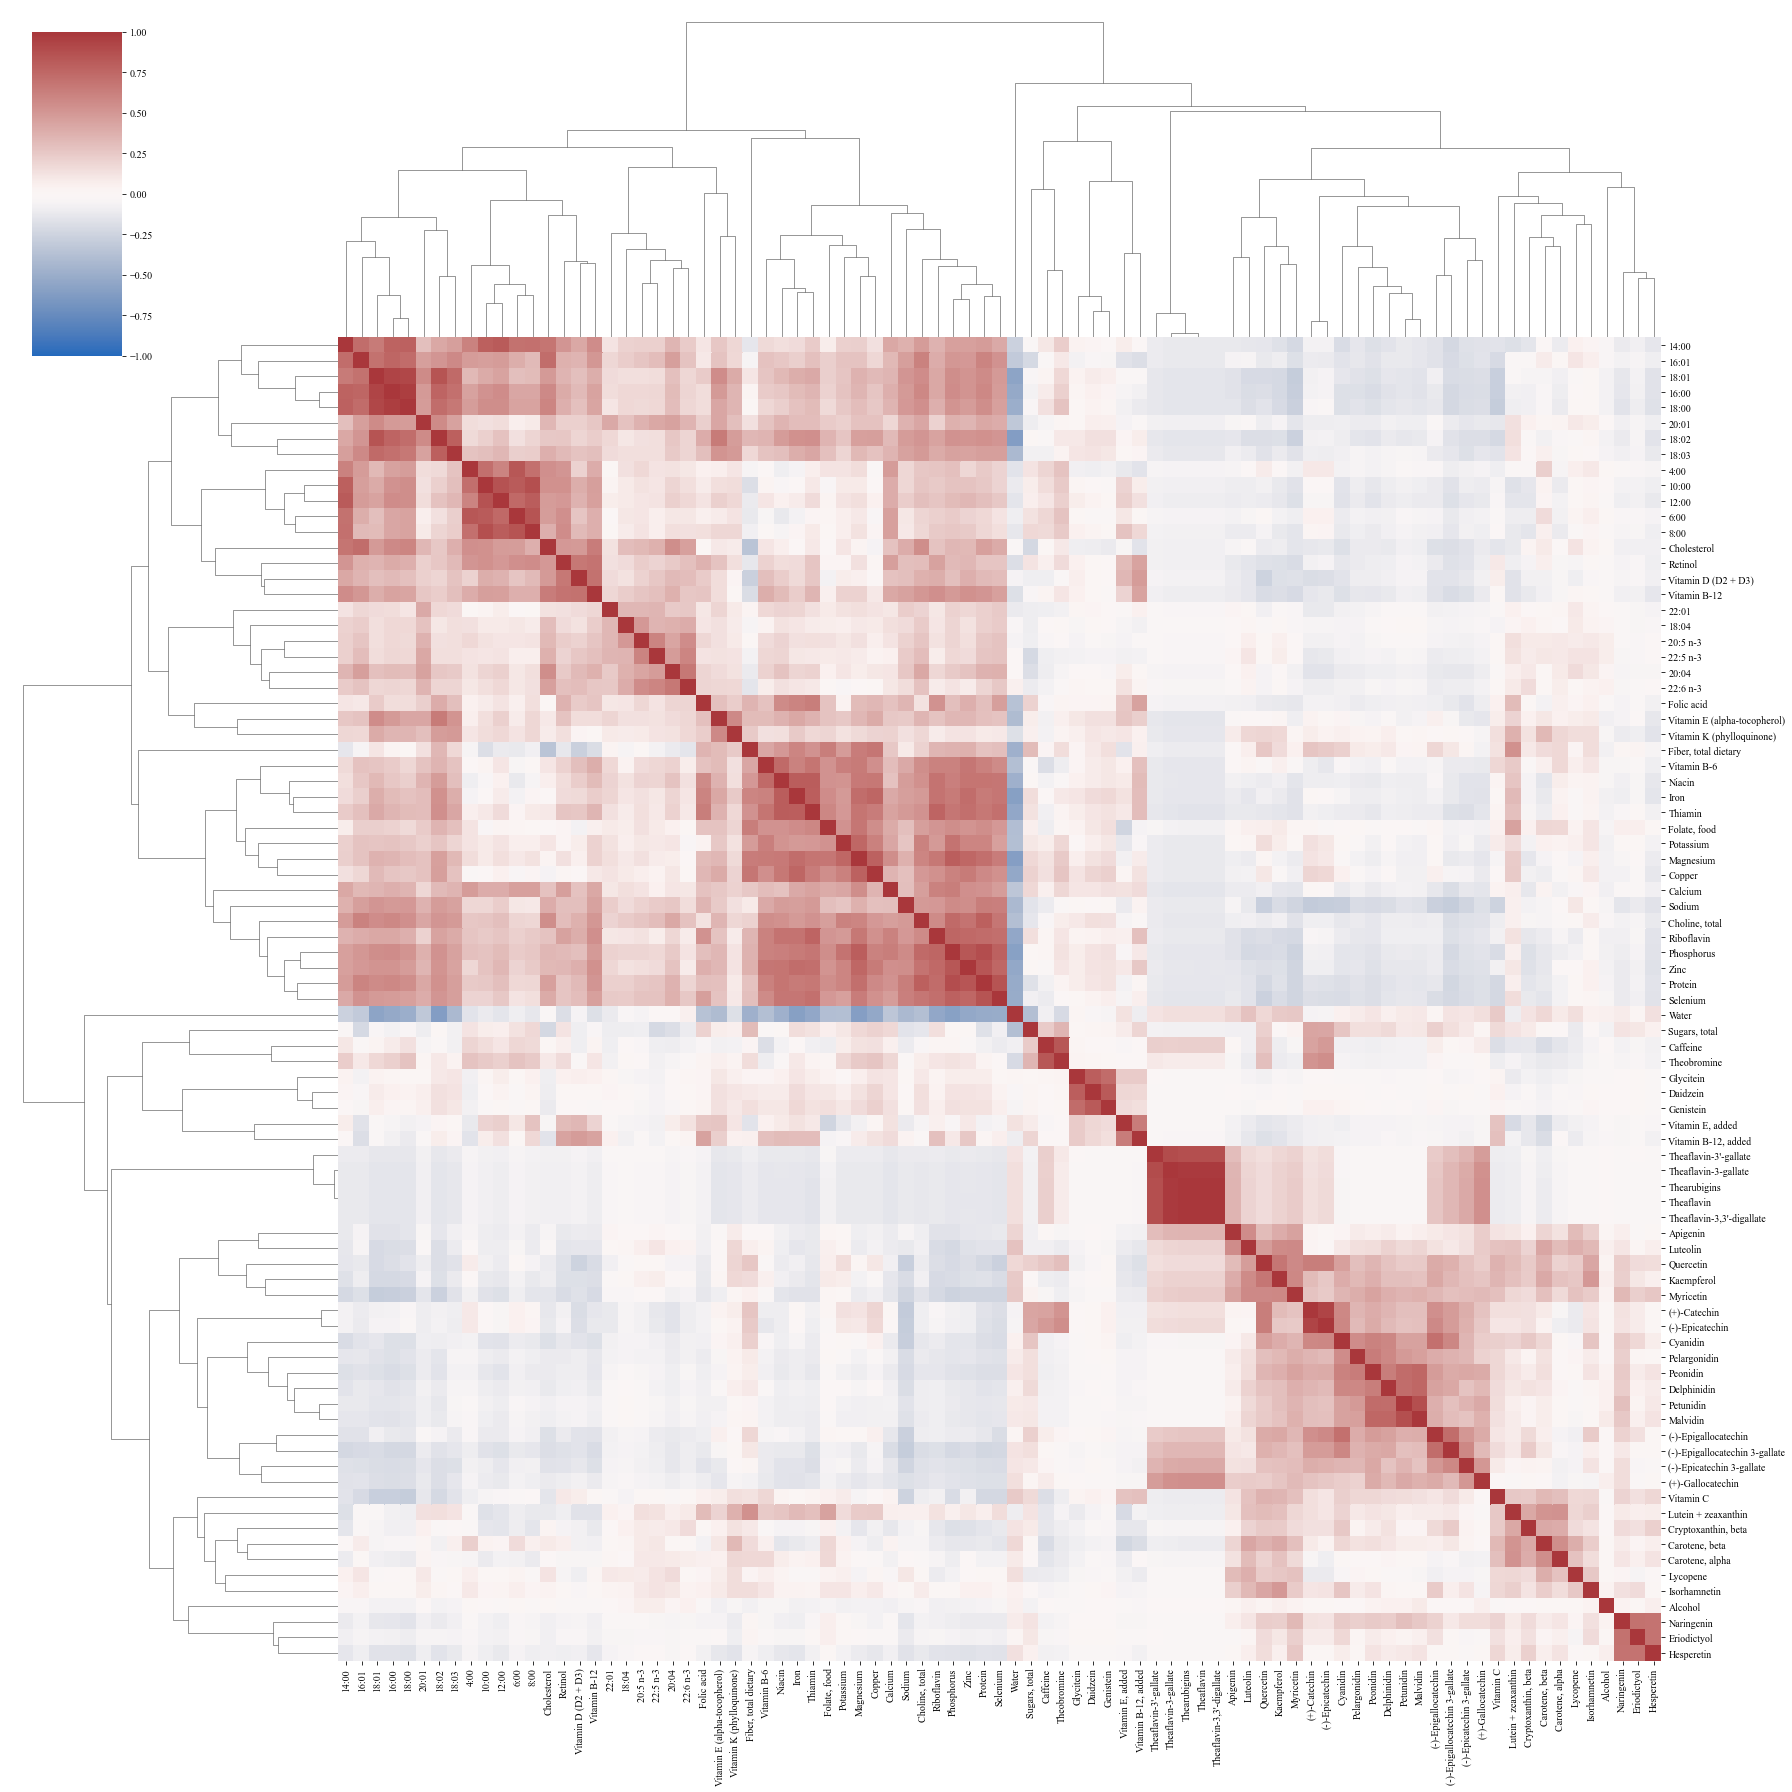

In [11]:
sns.clustermap(Xsel.corr(method='spearman'), vmin=-1, vmax=1,figsize=(25,25), cmap="vlag");

# Generate Network from High Correlation Values and High Predictability

In [12]:
valcorr=0.80
G = nx.Graph()
G.add_edges_from([(selnut[i],selnut[j],{'corrS': corrmatSS.loc[selnut[i],selnut[j]]} ) for i in range(len(selnut)) for j in range(i+1,len(selnut)) if corrmatSS.loc[selnut[i],selnut[j]]>=valcorr])

valdep=0.80
H = nx.Graph()
H.add_edges_from([(selnut[i],selnut[j],{'Rsquared': DmatrixSel[i,j]} ) for i in range(len(selnut)) for j in range(i+1,len(selnut)) if  (DmatrixSel[i,j]>=valdep) &(Dsel.loc[selnut[i], 'Dependence']>=valdep)])

In [13]:
print('Number of connected components Corr Training')
print(nx.number_connected_components(G))

print('Number of connected components Dependence')
print(nx.number_connected_components(H))

Number of connected components Corr Training
9
Number of connected components Dependence
10


In [14]:
# components in Corr Training
[c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

[{'10:00', '12:00', '14:00', '4:00', '6:00', '8:00'},
 {'Magnesium', 'Phosphorus', 'Protein', 'Selenium', 'Zinc'},
 {'Theaflavin',
  "Theaflavin-3'-gallate",
  "Theaflavin-3,3'-digallate",
  'Theaflavin-3-gallate',
  'Thearubigins'},
 {'16:00', '18:00', '18:01', '18:02'},
 {'Iron', 'Niacin', 'Thiamin'},
 {'Caffeine', 'Theobromine'},
 {'Daidzein', 'Genistein'},
 {'Malvidin', 'Petunidin'},
 {'(+)-Catechin', '(-)-Epicatechin'}]

In [15]:
# components in Dependence
[c for c in sorted(nx.connected_components(H), key=len, reverse=True)]

[{'Caffeine', 'Theobromine'},
 {'Vitamin B-12, added', 'Vitamin E, added'},
 {'4:00', '6:00'},
 {'10:00', '8:00'},
 {'16:00', '18:00'},
 {'Daidzein', 'Genistein'},
 {'Malvidin', 'Petunidin'},
 {'(+)-Catechin', '(-)-Epicatechin'},
 {'(-)-Epicatechin 3-gallate', '(-)-Epigallocatechin 3-gallate'},
 {'Eriodictyol', 'Hesperetin'}]

In [16]:
import pyvis
from pyvis.network import Network

#union network
valcorr=0.8
UN = nx.Graph()
UN.add_edges_from([(selnut[i],selnut[j]) for i in range(len(selnut)) for j in range(i+1,len(selnut)) if corrmatSS.loc[selnut[i],selnut[j]]>=valcorr])
valdep=0.8
UN.add_edges_from([(selnut[i],selnut[j]) for i in range(len(selnut)) for j in range(i+1,len(selnut)) if (DmatrixSel[i,j]>=valdep)&(Dsel.loc[selnut[i], 'Dependence']>=valdep)])


net=Network(notebook=True)
net.from_nx(UN)
net.show("./output_data/feature_dependence.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [17]:
# components in Dependence and Corr Training
[list(c) for c in sorted(nx.connected_components(UN), key=len, reverse=True)]

[['14:00', '12:00', '10:00', '4:00', '6:00', '8:00'],
 ['Protein', 'Zinc', 'Magnesium', 'Selenium', 'Phosphorus'],
 ['Theaflavin-3-gallate',
  'Theaflavin',
  "Theaflavin-3'-gallate",
  "Theaflavin-3,3'-digallate",
  'Thearubigins'],
 ['18:00', '16:00', '18:01', '18:02'],
 ['Iron', 'Thiamin', 'Niacin'],
 ['Caffeine', 'Theobromine'],
 ['Genistein', 'Daidzein'],
 ['Petunidin', 'Malvidin'],
 ['(+)-Catechin', '(-)-Epicatechin'],
 ['Vitamin B-12, added', 'Vitamin E, added'],
 ['(-)-Epicatechin 3-gallate', '(-)-Epigallocatechin 3-gallate'],
 ['Hesperetin', 'Eriodictyol']]

# Selection of Features for Grouped Cross Validation

In [18]:
featuresgroups=[list(c) for c in sorted(nx.connected_components(UN), key=len, reverse=True)]+list(set(selnut)-set(UN.nodes))

In [19]:
# multiple instances to control for the fluctuations (it takes a long time, it should be run in parallel)
reproduceflag=True

if reproduceflag:
    dfimportances=joblib.load('./input_data/dfimportances.pkl')
    
else:
    numinstances=20
    listdf=[]

    for ind in tqdm(range(numinstances)):
        df=cv_importances_features_custom(Xsel,y,splitsWNP, smoteflag, featuresgroups);
        listdf.append(df.reset_index())

    dfimportances=pd.concat(listdf)
    joblib.dump(dfimportances, './output_data/dfimportances.pkl')

In [20]:
# grouping
dfimportances_grouped=dfimportances.groupby(['Feature']).agg(
                                                 avgImportance=pd.NamedAgg(column='Importance', aggfunc='mean'),
                                                 stdImportance=pd.NamedAgg(column='Importance', aggfunc='std'))

dfimportances_grouped['includeZero']=[ (m-s) <= 0 <= (m+s) for (m,s) in dfimportances_grouped.values]
dfimportances_grouped=dfimportances_grouped.sort_values('avgImportance', ascending=False)
dfimportances_grouped

,avgImportance,stdImportance,includeZero
Feature,,,
Sodium,0.010587,0.001446,False
"Sugars, total",0.004343,0.002162,False
Water,0.003586,0.002231,False
Protein\nMagnesium\nZinc\nPhosphorus\nSelenium,0.003385,0.002312,False
Potassium,0.002626,0.001832,False
"Choline, total",0.001785,0.001764,False
Folic acid,0.001229,0.002070,True
18:00\n18:02\n16:00\n18:01,0.001028,0.002053,True
Vitamin C,0.000926,0.002048,True


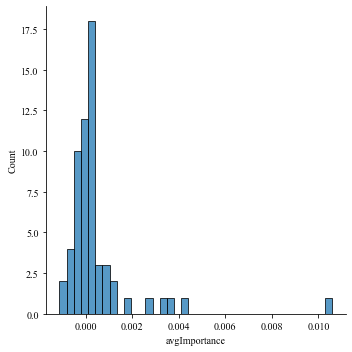

In [21]:
# distribution of the average importance
sns.displot(dfimportances_grouped['avgImportance'])

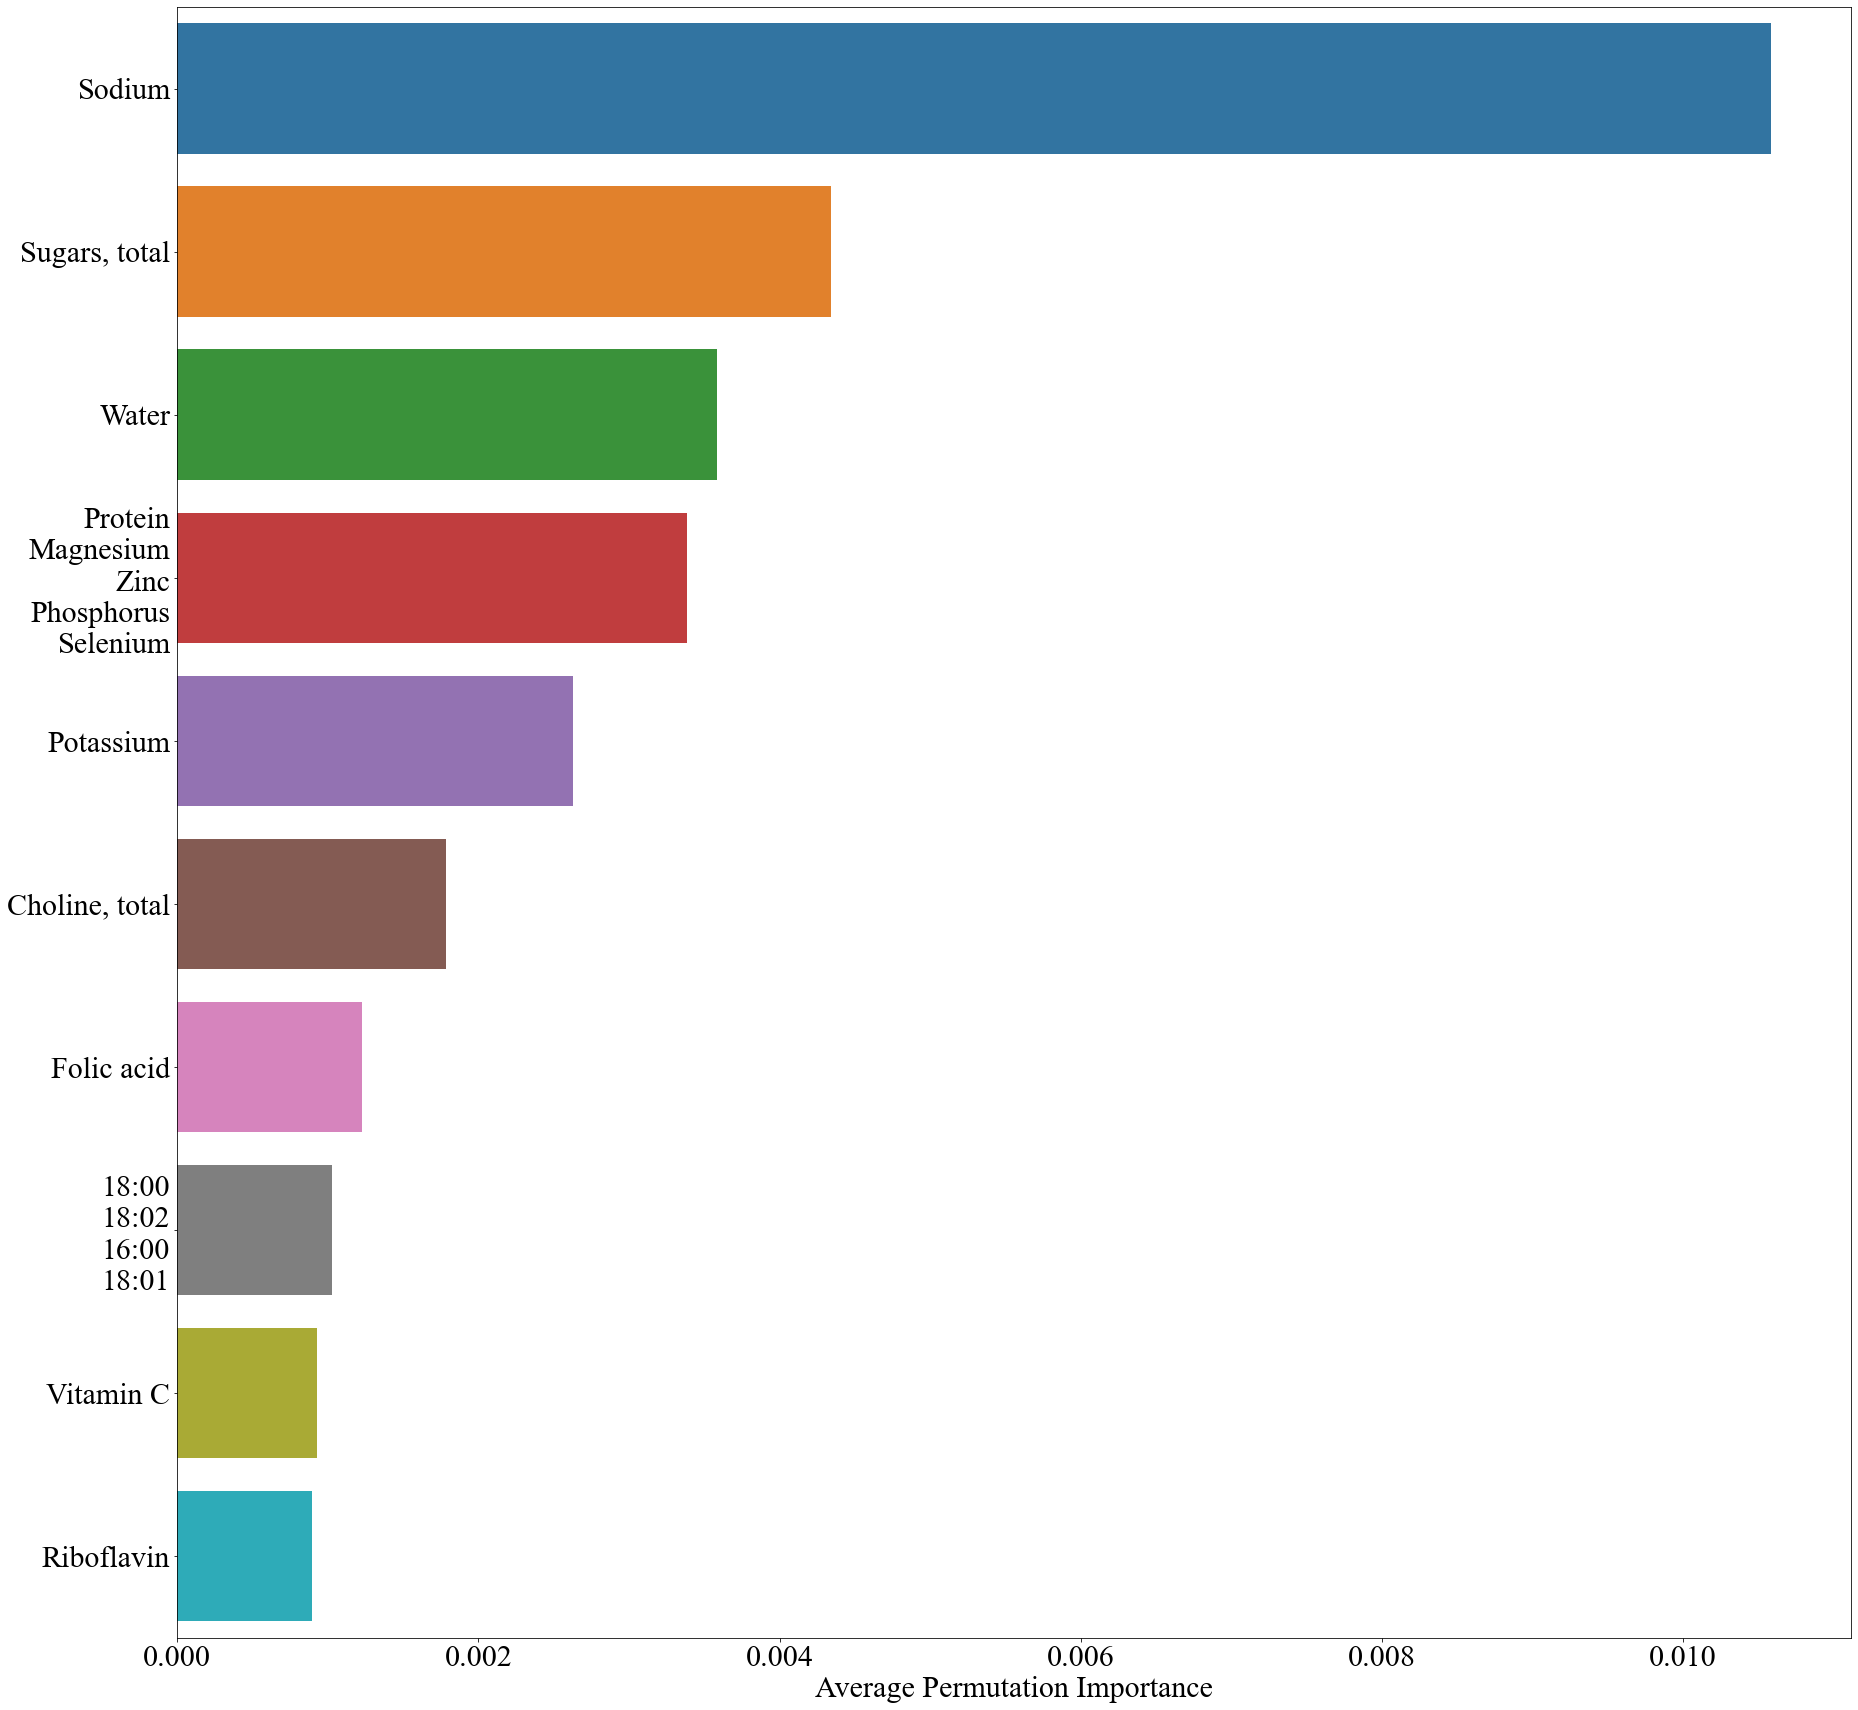

In [22]:
plt.figure(figsize = (30, 30))
ax = sns.barplot(x="avgImportance",y="Feature", data=dfimportances_grouped.iloc[0:10].reset_index())
ax.set_ylabel('')
ax.set_xlabel('Average Permutation Importance', fontsize=30)
plt.setp(ax.get_xticklabels(), fontsize=30)
plt.setp(ax.get_yticklabels(), fontsize=30);